Todo:
1)year by year breakdown of florida code is runnning (needed to get the names of non deduped list since employee in multiple years)      

2)Need to clean up some charts...remove the first chart, add some state means from census

3) Department and titles some files have and some dont...lots of job titles...looksl like tedious work

4)for states w/ time series time trend

In [ ]:
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name
import pandas as pd
from os import listdir
from os.path import isfile, join

root = '/Users/seunglee/Downloads/project/'


Unzip the .7z files to one directory...here it's "raw_data"

In [ ]:
import pandas as pd
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name


root = '/Users/seunglee/Downloads/project/'


race_summary_not_wiki = pd.DataFrame()
race_summary_wiki = pd.DataFrame()
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']
onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df_org = pd.read_csv(root+f)
    df = df_org.drop_duplicates(subset=['Employee Name'])
    df = df[['Employee Name']]
    
    df['ln'] = df['Employee Name'].str.split(',').str[0].str.lower()
    df['fn'] = df['Employee Name'].str.split(',').str[1].str.split(' ').str[1].str.strip()
    original_columns = list(df.columns)
    
    models_str = []
    for model in [census_ln, pred_census_ln, pred_fl_reg_ln, pred_fl_reg_name]:
        model_name = model.__name__
        models_str.append('race_'+model_name)
        if(model_name=='census_ln'): 
            df = model(df, 'ln')
            df.replace('(S)', '0', inplace=True)
            race_cols = df.columns[df.columns.str.startswith('pct')]
            for col in race_cols:
                df[col] = df[col].astype('double')
            df['race'] = df[race_cols].idxmax(axis=1)
        elif(model_name=='pred_wiki_name'):
            df = model(df, 'fn', 'ln')
        elif(model_name=='pred_fl_reg_name'):
            df = model(df, lname_col='ln', fname_col='fn')
        else:
            df = model(df, 'ln')
        
        df.rename(columns={'race':'race_'+model_name}, inplace=True) 
    
    df_org = df_org.merge(df, how='left', on=['Employee Name'])
    df_org.to_csv(root+'employee_race/data/'+f)
    print('done:', f)
    
#############################################################################

onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f, index_col=[0])
    start_ind = pd.DataFrame(df.dtypes).reset_index()
    temp = start_ind.loc[start_ind['index']=='ln'].index[0]
    
    keep_cols1 = list(start_ind.loc[:temp-1, 'index'])
    keep_cols2 = list(df.columns[df.columns.str.startswith('race')])
    df2 = df[keep_cols1+keep_cols2]
    df2.to_csv(root+'employee_race/data/'+f.replace('.csv', '_all.csv'))



#############################################################################





Data description over years government

In [ ]:



def get_stats(df, df_description, name, year_begin=2014, year_end=2014, race='all', model='n/a'):
    print(name, year_begin, year_end, race, model)
    counter = df_description.shape[0]
    skip = 1
    try:
        df_prev = df_description.loc[
                (df_description.gov == name)&
                (df_description.year_period_start==year_begin)&
                (df_description.year_period_end==year_end)&(df_description.model=='n/a')].drop_duplicates(keep='last')
        
        n_observations = df_prev['n_observations'].values[0]
        n_uniq = df_prev['n_uniq_observations'].values[0]
        avg_salary = df_prev['salary_avg'].values[0]
        median_salary = df_prev['salary_median'].values[0]
        uniq_avg_salary = df_prev['uniq_salary_avg'].values[0]
        uniq_median_salary = df_prev['uniq_salary_median'].values[0]
    except:
        print('errror')
        skip = 0
        
    df_uniq = df.drop_duplicates(subset=['Employee Name'])
    df_description.loc[counter, 'gov'] = name
    df_description.loc[counter, 'year_period_start'] = year_begin
    df_description.loc[counter, 'year_period_end'] = year_end
    df_description.loc[counter, 'state'] = 'fl'
    df_description.loc[counter, 'race'] = race
    df_description.loc[counter, 'model'] = model

    df_description.loc[counter, 'n_observations'] = df.shape[0]  
    df_description.loc[counter, 'salary_avg'] = df[pay].mean()/1e3    
    df_description.loc[counter, 'salary_median'] = df[pay].median()/1e3
    df_description.loc[counter, 'salary_min'] = df[pay].min()/1e3
    df_description.loc[counter, 'salary_max'] = df[pay].max()/1e3
    df_description.loc[counter, 'salary_std'] = df[pay].std()/1e3   
    
    df_description.loc[counter, 'n_uniq_observations'] = df_uniq.shape[0]  
    df_description.loc[counter, 'uniq_salary_avg'] = df_uniq[pay].mean()/1e3    
    df_description.loc[counter, 'uniq_salary_median'] = df_uniq[pay].median()/1e3
    df_description.loc[counter, 'uniq_salary_min'] = df_uniq[pay].min()/1e3
    df_description.loc[counter, 'uniq_salary_max'] = df_uniq[pay].max()/1e3
    df_description.loc[counter, 'uniq_salary_std'] = df_uniq[pay].std()/1e3  
    
    if(skip>0):
        df_description.loc[counter, 'race_composition'] = df.shape[0]/n_observations
        df_description.loc[counter, 'race_composition_uniq'] = df_uniq.shape[0]/n_uniq
      
        df_description.loc[counter, 'ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'salary_avg']/avg_salary 
        df_description.loc[counter, 'uniq_ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_avg']/uniq_avg_salary 
                           
        df_description.loc[counter, 'ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'salary_median']/median_salary 
        df_description.loc[counter, 'uniq_ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_median']/uniq_median_salary 
    return df_description

    
 
pay_map = {'state':'Total Compensation', 'cities':'Salary', 'k12':'Salary', 'counties':'Salary', 'university':'Annual Salary'}
onlyfiles=['university_2014.csv', 'state_1995_2014_all.csv', 'k12_1997_2014_all.csv',
           'counties_1995_2014_all.csv', 'cities_1995_2014_all.csv']
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']

df_description = pd.DataFrame()
for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f)
    name = f.split('_')[0]
    pay = pay_map[name]
    year_def1 = f.split('_')[1].replace('.csv', '')
    try:
        year_def2 = f.split('_')[2].replace('.csv', '')
    except:
        year_def2 = year_def1
        
    if(df[pay].dtype=='O'):
        df[pay] = df[pay].str.replace('$', '')
        df[pay] = df[pay].str.replace(',', '')
        df[pay] = df[pay].astype('double')
    df = df.loc[df[pay]>0]
    get_stats(df, df_description, name, year_begin=year_def1, year_end=year_def2)
    
    for model in models:
        for race in ['white', 'hispanic', 'black', 'asian']:
            if(race=='asian'):    
                df_race = df.loc[(df[model].str.contains(race))|(df[model].str.contains('api'))]
            else:
                df_race = df.loc[(df[model].str.contains(race))&~(pd.isna(df[model]))]           
            get_stats(df_race, df_description, name, race=race, model=model,
                      year_begin=year_def1, year_end=year_def2)
            
            
    if('Year' in df.columns):
        for year in df.Year.unique():
            df_year = df.loc[df.Year==year]
            get_stats(df_year, df_description, name, year_begin=year, year_end=year)
            for model in models:
                for race in ['white', 'hispanic', 'black', 'asian']:
                    if(race=='asian'):    
                        df_race = df_year.loc[(df_year[model].str.contains(race))|(df_year[model].str.contains('api'))]
                    else:
                        df_race = df_year.loc[(df_year[model].str.contains(race))&~(pd.isna(df_year[model]))]           
                    get_stats(df_race, df_description, name, race=race, model=model,
                              year_begin=year, year_end=year)
         
    
df_description.to_csv(root+'employee_race/data/florida_stats.csv')


In [ ]:
df_description.sort_values(by=['gov', 'year'], inplace=True)
df_description.head()

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

root = '/Users/seunglee/Downloads/project/'
df_description = pd.read_csv(root+'employee_race/data/florida_stats.csv')

df_all = df_description.drop_duplicates(['gov', 'race', 'model'])
df_all_gb = df_all.groupby(['gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
asian = df_all_gb.loc[df_all_gb.race=='asian'].sort_values(by='gov')
hispanic = df_all_gb.loc[df_all_gb.race=='hispanic'].sort_values(by='gov')
black = df_all_gb.loc[df_all_gb.race=='black'].sort_values(by='gov')

x = np.arange(5)  
width = 0.35 
margin = 0.05
width = (1.-2.*margin)/3



Text(0.5, 0.98, 'Race Composition by Instituion (Mean of 4 race models)')

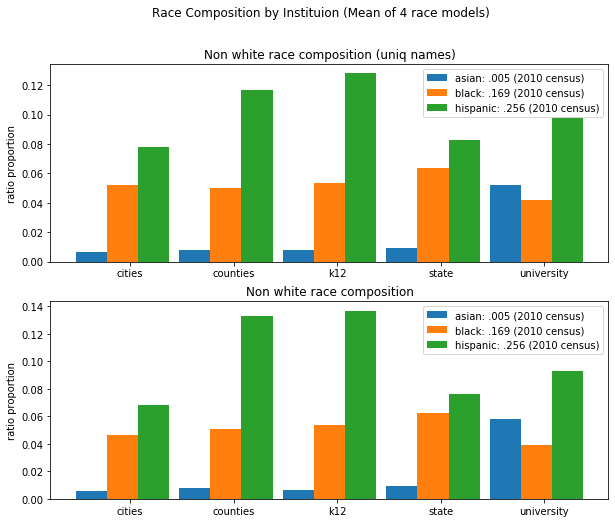

In [2]:

# Race Proportion
##############################################################
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))    
ax[0].bar(x - 5*width/4, asian.race_composition_uniq, width, label='asian: .005 (2010 census)')
ax[0].bar(x - width/4, black.race_composition_uniq, width, label='black: .169 (2010 census)')
ax[0].bar(x + 3*width/4, hispanic.race_composition_uniq, width, label='hispanic: .256 (2010 census)')
ax[0].set_ylabel('ratio proportion')
ax[0].set_title('Non white race composition (uniq names)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(asian.gov)
ax[0].legend()

ax[1].bar(x - 5*width/4, asian.race_composition, width, label='asian: .005 (2010 census)')
ax[1].bar(x - width/4, black.race_composition, width, label='black: .169 (2010 census)')
ax[1].bar(x + 3*width/4, hispanic.race_composition, width, label='hispanic: .256 (2010 census)')
ax[1].set_ylabel('ratio proportion')
ax[1].set_title('Non white race composition')
ax[1].set_xticks(x)
ax[1].set_xticklabels(asian.gov)
ax[1].legend()
plt.suptitle('Race Composition by Instituion (Mean of 4 race models)')
##############################################################



In [3]:

df_all['total_salary'] = df_all.n_observations * df_all.salary_avg
df_all['total_salary_uniq'] = df_all.n_uniq_observations * df_all.uniq_salary_avg

df_all_pay_gb = df_all.groupby(['gov', 'race']).sum()[['total_salary',
                          'n_observations', 'n_uniq_observations', 'total_salary_uniq']].reset_index()

df_all_pay_gb['avg_salary'] = df_all_pay_gb['total_salary']/df_all_pay_gb['n_observations']
df_all_pay_gb['avg_salary_uniq'] = df_all_pay_gb['total_salary_uniq']/df_all_pay_gb['n_uniq_observations']

asian = df_all_pay_gb.loc[df_all_pay_gb.race=='asian'].sort_values(by='gov')
hispanic = df_all_pay_gb.loc[df_all_pay_gb.race=='hispanic'].sort_values(by='gov')
black = df_all_pay_gb.loc[df_all_pay_gb.race=='black'].sort_values(by='gov')
white = df_all_pay_gb.loc[df_all_pay_gb.race=='white'].sort_values(by='gov')
population = df_all_pay_gb.loc[df_all_pay_gb.race=='all'].sort_values(by='gov')

x = np.arange(5)  
width = 0.35 
margin = 0.05
width = (1.-2.*margin)/5


/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 0.98, 'Average Salary by Instituion and Race (Mean of 4 race models)')

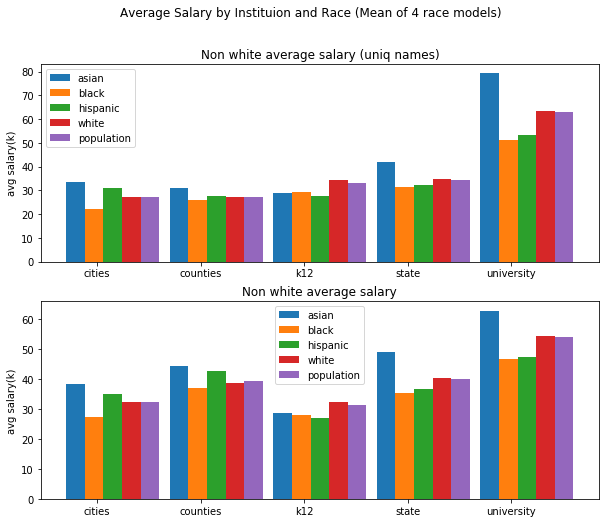

In [4]:

# Race Pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))    
ax[0].bar(x - 7*width/6, asian.avg_salary_uniq, width, label='asian')
ax[0].bar(x - 1*width/6, black.avg_salary_uniq, width, label='black')
ax[0].bar(x + 5*width/6, hispanic.avg_salary_uniq, width, label='hispanic')
ax[0].bar(x + 11*width/6, white.avg_salary_uniq, width, label='white')
ax[0].bar(x + 17*width/6, population.avg_salary_uniq, width, label='population')
ax[0].set_ylabel('avg salary(k)')
ax[0].set_title('Non white average salary (uniq names)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(asian.gov)
ax[0].legend()

ax[1].bar(x - 7*width/6, asian.avg_salary, width, label='asian')
ax[1].bar(x - 1*width/6, black.avg_salary, width, label='black')
ax[1].bar(x + 5*width/6, hispanic.avg_salary, width, label='hispanic')
ax[1].bar(x + 11*width/6, white.avg_salary, width, label='white')
ax[1].bar(x + 17*width/6, population.avg_salary, width, label='population')
ax[1].set_ylabel('avg salary(k)')
ax[1].set_title('Non white average salary')
ax[1].set_xticks(x)
ax[1].set_xticklabels(asian.gov)
ax[1].legend()
plt.suptitle('Average Salary by Instituion and Race (Mean of 4 race models)')
##############################################################



In [5]:
df_years = df_description.loc[df_description.year_period_start == df_description.year_period_end]
df_year_gb = df_years.groupby(['year_period_start', 'gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
df_year_gb = df_year_gb.loc[df_year_gb.gov!='university']
df_year_gb['year'] = df_year_gb['year_period_start'].astype('int')
df_year_gb['log_composition'] = np.log(df_year_gb.race_composition)

asian = df_year_gb.loc[df_year_gb.race=='asian'].sort_values(by=['race', 'gov', 'year_period_start'])
hispanic = df_year_gb.loc[df_year_gb.race=='hispanic'].sort_values(by=['race', 'gov', 'year_period_start'])
black = df_year_gb.loc[df_year_gb.race=='black'].sort_values(by=['race', 'gov', 'year_period_start'])



Text(0.5, 0.98, 'Race Composition Time Series by Race (Mean of 4 race models)')

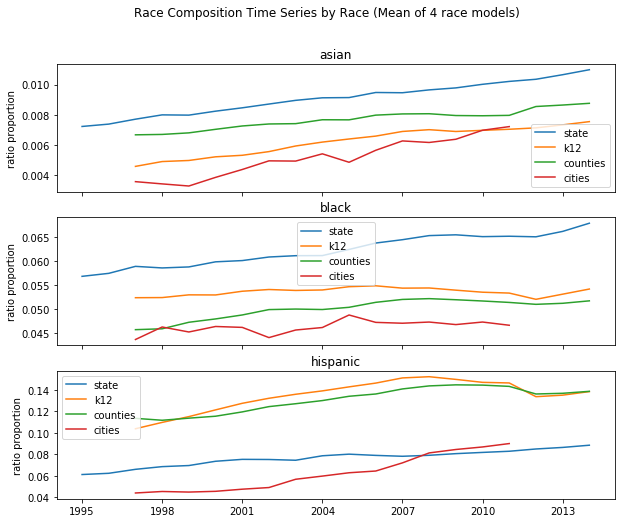

In [16]:
from matplotlib.ticker import MaxNLocator


# time series composition
##############################################################
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'race_composition'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'race_composition'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'race_composition'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'race_composition'], label='cities')
ax[0].set_ylabel('ratio proportion')
ax[0].set_title('asian')
ax[0].legend()

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'race_composition'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'race_composition'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'race_composition'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'race_composition'], label='cities')
ax[1].set_ylabel('ratio proportion')
ax[1].set_title('black')
ax[1].legend()

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'race_composition'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'race_composition'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'race_composition'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'race_composition'], label='cities')
ax[2].set_ylabel('ratio proportion')
ax[2].set_title('hispanic')
ax[2].legend()
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Race Composition Time Series by Race (Mean of 4 race models)')
##############################################################


In [17]:

start_years = asian.drop_duplicates(subset=['gov'])
asian['log_diff'] = np.nan
black['log_diff'] = np.nan
hispanic['log_diff'] = np.nan


for i in range(4):
    subset= asian.loc[(asian.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_composition.diff()
    asian.loc[pd.isna(asian.log_diff), 'log_diff'] = subset.log_diff
    
    subset= black.loc[(black.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_composition.diff()
    black.loc[pd.isna(black.log_diff), 'log_diff'] = subset.log_diff

    subset= hispanic.loc[(hispanic.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_composition.diff()
    hispanic.loc[pd.isna(hispanic.log_diff), 'log_diff'] = subset.log_diff    
    
    

/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Text(0.5, 0.98, 'Log Difference of Race Composition by Race')

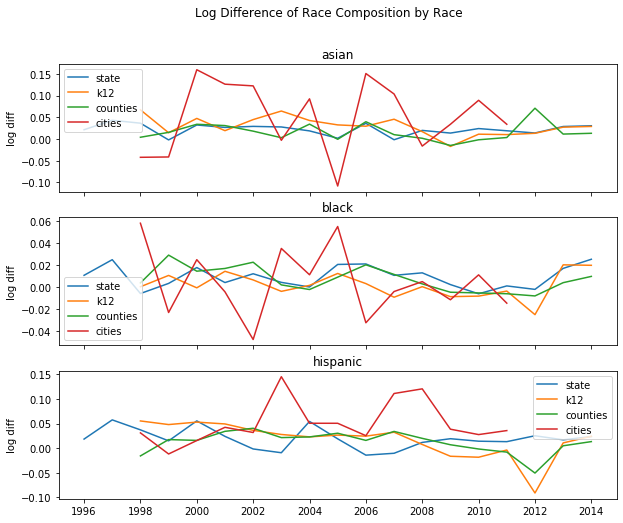

In [19]:

# time series log diff by race
##############################################################
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'log_diff'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'log_diff'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'log_diff'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'log_diff'], label='cities')
ax[0].set_ylabel('log diff')
ax[0].set_title('asian')
ax[0].legend()

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'log_diff'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'log_diff'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'log_diff'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'log_diff'], label='cities')
ax[1].set_ylabel('log diff')
ax[1].set_title('black')
ax[1].legend()

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'log_diff'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'log_diff'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'log_diff'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'log_diff'], label='cities')
ax[2].set_ylabel('log diff')
ax[2].set_title('hispanic')
ax[2].legend()
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.suptitle('Log Difference of Race Composition by Race')


##############################################################


Text(0.5, 0.98, 'Log Difference of Race Composition by Institution')

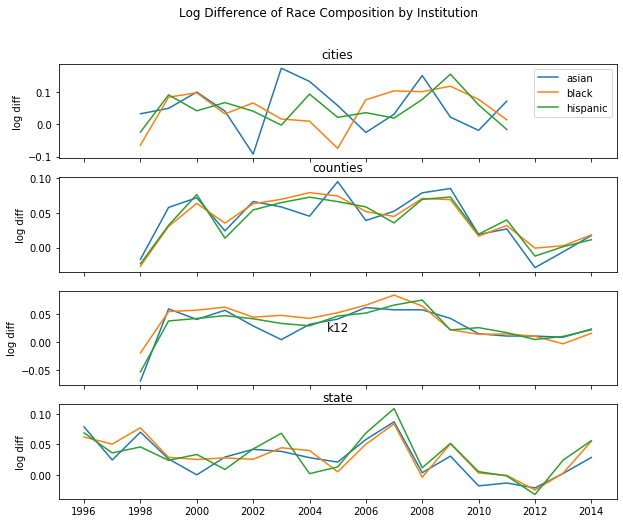

In [32]:

# time series log diff by inst
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'log_diff'], label='asian')
ax[0].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'log_diff'], label='black')
ax[0].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'log_diff'], label='hispanic')
ax[0].set_ylabel('log diff')
ax[0].set_title('cities')
ax[0].legend()

ax[1].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'log_diff'], label='asian')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'log_diff'], label='black')
ax[1].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'log_diff'], label='hispanic')
ax[1].set_ylabel('log diff')
ax[1].set_title('counties')

ax[2].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'log_diff'], label='asian')
ax[2].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'log_diff'], label='black')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'log_diff'], label='hispanic')
ax[2].set_ylabel('log diff')
ax[2].set_title('k12', pad=-40)

ax[3].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'log_diff'], label='asian')
ax[3].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'log_diff'], label='black')
ax[3].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'log_diff'], label='hispanic')
ax[3].set_ylabel('log diff')
ax[3].set_title('state', pad=-40)
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Log Difference of Race Composition by Institution')

##############################################################



In [22]:


df_years['total_salary'] = df_years.n_observations * df_years.salary_avg
df_years['total_salary_uniq'] = df_years.n_uniq_observations * df_years.uniq_salary_avg

df_years_pay_gb = df_years.groupby(['year_period_start', 'gov', 'race']).sum()[['total_salary',
                          'n_observations', 'n_uniq_observations', 'total_salary_uniq']].reset_index()
df_years_pay_gb['year'] = df_years_pay_gb['year_period_start'].astype('int')
df_years_pay_gb['avg_salary'] = df_years_pay_gb['total_salary']/df_years_pay_gb['n_observations']
df_years_pay_gb['avg_salary_uniq'] = df_years_pay_gb['total_salary_uniq']/df_years_pay_gb['n_uniq_observations']
df_years_pay_gb['log_salary'] = np.log(df_years_pay_gb.avg_salary)

asian = df_years_pay_gb.loc[df_years_pay_gb.race=='asian'].sort_values(by=['gov', 'year'])
hispanic = df_years_pay_gb.loc[df_years_pay_gb.race=='hispanic'].sort_values(by=['gov', 'year'])
black = df_years_pay_gb.loc[df_years_pay_gb.race=='black'].sort_values(by=['gov', 'year'])
white = df_years_pay_gb.loc[df_years_pay_gb.race=='white'].sort_values(by=['gov', 'year'])
population = df_years_pay_gb.loc[df_years_pay_gb.race=='all'].sort_values(by=['gov', 'year'])


/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 0.98, 'Race Composition Time Series by Race (Mean of 4 race models)')

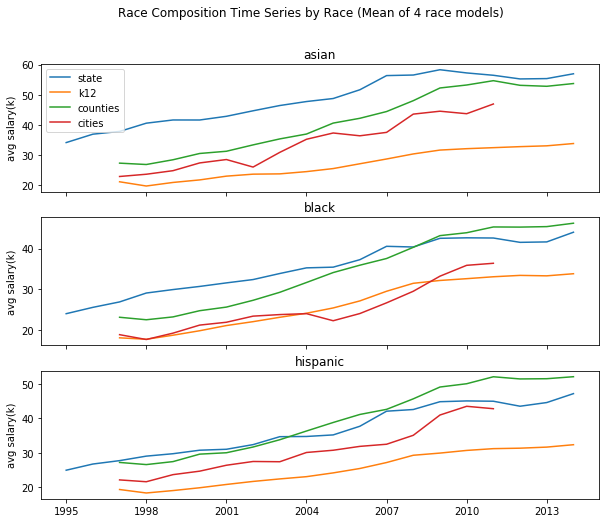

In [31]:

# time series pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'avg_salary'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'avg_salary'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'avg_salary'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'avg_salary'], label='cities')
ax[0].set_ylabel('avg salary(k)')
ax[0].set_title('asian')
ax[0].legend()

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'avg_salary'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'avg_salary'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'avg_salary'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'avg_salary'], label='cities')
ax[1].set_ylabel('avg salary(k)')
ax[1].set_title('black')

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'avg_salary'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'avg_salary'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'avg_salary'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'avg_salary'], label='cities')
ax[2].set_ylabel('avg salary(k)')
ax[2].set_title('hispanic')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))


plt.suptitle('Race Composition Time Series by Race (Mean of 4 race models)')
##############################################################




In [25]:

start_years = asian.drop_duplicates(subset=['gov'])
asian['log_diff'] = np.nan
black['log_diff'] = np.nan
hispanic['log_diff'] = np.nan
white['log_diff'] = np.nan


for i in range(4):
    subset= asian.loc[(asian.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_salary.diff()
    asian.loc[pd.isna(asian.log_diff), 'log_diff'] = subset.log_diff
    
    subset= black.loc[(black.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_salary.diff()
    black.loc[pd.isna(black.log_diff), 'log_diff'] = subset.log_diff

    subset= hispanic.loc[(hispanic.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_salary.diff()
    hispanic.loc[pd.isna(hispanic.log_diff), 'log_diff'] = subset.log_diff    
    
    subset= white.loc[(white.gov==start_years.gov.iloc[i])]
    subset['log_diff'] = subset.log_salary.diff()
    white.loc[pd.isna(white.log_diff), 'log_diff'] = subset.log_diff       
##############################################################


/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Text(0.5, 0.98, 'Log Difference of Avg Salary Composition by Race')

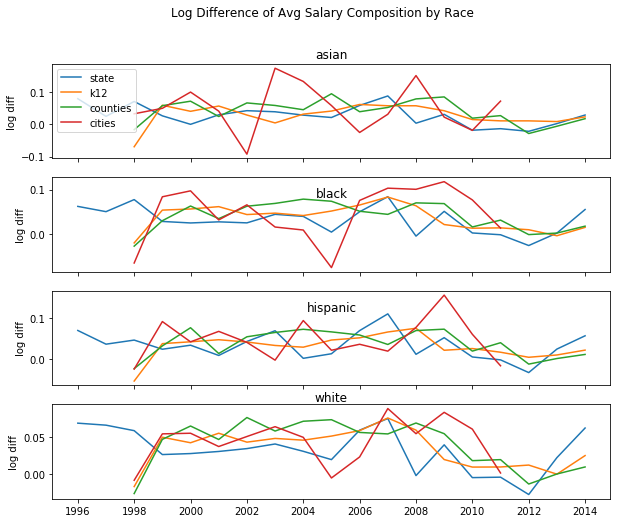

In [30]:
# time series log diff by race (pay)
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'log_diff'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'log_diff'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'log_diff'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'log_diff'], label='cities')
ax[0].set_ylabel('log diff')
ax[0].set_title('asian')
ax[0].legend()

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'log_diff'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'log_diff'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'log_diff'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'log_diff'], label='cities')
ax[1].set_ylabel('log diff')
ax[1].set_title('black', pad=-20)

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'log_diff'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'log_diff'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'log_diff'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'log_diff'], label='cities')
ax[2].set_ylabel('log diff')
ax[2].set_title('hispanic', pad=-20)

ax[3].plot(white.loc[white.gov=='state', 'year'], white.loc[white.gov=='state', 'log_diff'], label='state')
ax[3].plot(white.loc[white.gov=='k12', 'year'], white.loc[white.gov=='k12', 'log_diff'], label='k12')
ax[3].plot(white.loc[white.gov=='counties', 'year'], white.loc[white.gov=='counties', 'log_diff'], label='counties')
ax[3].plot(white.loc[white.gov=='cities', 'year'], white.loc[white.gov=='cities', 'log_diff'], label='cities')
ax[3].set_ylabel('log diff')
ax[3].set_title('white', pad=-20)
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Log Difference of Avg Salary Composition by Race')

##############################################################


Text(0.5, 0.98, 'Log Difference of Avg Salary by Institution')

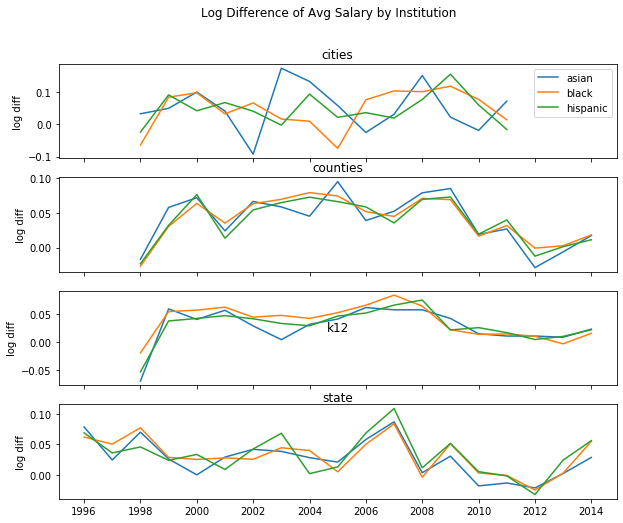

In [29]:


# time series log diff by inst
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(10, 8),sharex=True)    
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'log_diff'], label='asian')
ax[0].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'log_diff'], label='black')
ax[0].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'log_diff'], label='hispanic')
ax[0].set_ylabel('log diff')
ax[0].set_title('cities')
ax[0].legend()

ax[1].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'log_diff'], label='asian')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'log_diff'], label='black')
ax[1].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'log_diff'], label='hispanic')
ax[1].set_ylabel('log diff')
ax[1].set_title('counties')

ax[2].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'log_diff'], label='asian')
ax[2].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'log_diff'], label='black')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'log_diff'], label='hispanic')
ax[2].set_ylabel('log diff')
ax[2].set_title('k12', pad=-40)

ax[3].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'log_diff'], label='asian')
ax[3].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'log_diff'], label='black')
ax[3].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'log_diff'], label='hispanic')
ax[3].set_ylabel('log diff')
ax[3].set_title('state', pad=-40)
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Log Difference of Avg Salary by Institution')
##############################################################


Get distribution of races implied by the models


State mean from 2010 census.
https://en.wikipedia.org/wiki/Demographics_of_Florida